We have a large database of possible hex maze configs.
Each config has a set of attributes that we may want to use as keys in a lookup:
- length of optimal path from port 1 to 2
- length of optimal path from port 1 to 3
- length of optimal path from port 2 to 3
- difference in optimal path lengths
- number of critical choice points
- the choice point(s) themselves
- the optimal paths themselves (for each port pair)
- one big list of all optimal paths
    - could be useful to get mazes with the same (or not) set of all optimal paths - sort out mazes that are "unique" but only differ in trivial ways

Not yet added but maybe:
- number of cycles (?)
- dead ends (?)
    - number of dead ends? dead end hexes? dead end lengths? dead end paths? 


Also want to look up:
- set of barriers that differs by 1 barrier from a given set
- (with path lengths different?)


In [1]:
import pickle

# Load our saved set of good mazes
with open('set_of_good_mazes.pkl', 'rb') as file:
    good_mazes = pickle.load(file)

print("Number of good mazes in our database:", len(good_mazes))

Number of good mazes in our database: 49321


In [2]:
import networkx as nx
from hex_maze_utils import *

def create_maze_graph(barrier_set):
    '''
    Given a set of barriers defining a hex maze configuration, 
    return a networkx graph object representing the maze.
    '''
    
    # Create a new empty hex maze object
    maze_graph = create_hex_maze()
    
    # Remove the barriers
    for barrier in barrier_set:
        maze_graph.remove_node(barrier)
    return maze_graph


def get_maze_attributes(barrier_set):
    '''
    Given a set of barriers defining a maze, create a dictionary of attributes for that maze.
    
    Returns: a dictionary of maze attributes
    '''
    
    # Get the graph representation of the maze for us to do calculations on
    maze = create_maze_graph(barrier_set)

    # Get length of optimal paths between reward ports
    len12 = nx.shortest_path_length(maze, source=1, target=2)+1
    len13 = nx.shortest_path_length(maze, source=1, target=3)+1
    len23 = nx.shortest_path_length(maze, source=2, target=3)+1
    reward_path_lengths = [len12, len13, len23]
    path_length_difference = max(reward_path_lengths) - min(reward_path_lengths)
    
    # Get the optimal paths between reward ports
    optimal_paths_12 = list(nx.all_shortest_paths(maze, source=1, target=2))
    optimal_paths_13 = list(nx.all_shortest_paths(maze, source=1, target=3))
    optimal_paths_23 = list(nx.all_shortest_paths(maze, source=2, target=3))
    optimal_paths_all = []
    optimal_paths_all.extend(optimal_paths_12)
    optimal_paths_all.extend(optimal_paths_13)
    optimal_paths_all.extend(optimal_paths_23)
    
    # Get critical choice points
    choice_points = set(find_all_critical_choice_points(maze))
    num_choice_points = len(choice_points)
    
    # Get information about cycles
    cycle_basis = nx.cycle_basis(maze)
    num_cycles = len(cycle_basis)
    
    # Create a dictionary of attributes
    attributes = {'barriers': barrier_set, 'len12': len12, 'len13': len13, 'len23': len23, 
                  'reward_path_lengths': reward_path_lengths, 'path_length_difference': path_length_difference,
                  'optimal_paths_12': optimal_paths_12, 'optimal_paths_13': optimal_paths_13,
                  'optimal_paths_23': optimal_paths_23, 'optimal_paths_all': optimal_paths_all,
                  'choice_points': choice_points, 'num_choice_points': num_choice_points,
                 'cycles': cycle_basis, 'num_cycles': num_cycles}
    return attributes

In [3]:
from tqdm import tqdm
import pandas as pd

# Load our saved set of good mazes
with open('set_of_good_mazes.pkl', 'rb') as file:
    good_mazes = pickle.load(file)

# Convert it to a list so we can iterate
maze_configs = list(good_mazes)

maze_dicts = []
# Get info for each maze and add it to our dict
for maze in tqdm(maze_configs):
    maze_attributes = get_maze_attributes(maze)
    maze_dicts.append(maze_attributes)

# Create DataFrame
df = pd.DataFrame(maze_dicts)
print(df)

100%|███████████████████████████████████| 49321/49321 [00:14<00:00, 3516.20it/s]


                                   barriers  len12  len13  len23  \
0       (37, 7, 39, 41, 14, 46, 20, 23, 30)     15     17     21   
1      (34, 36, 37, 39, 10, 45, 14, 15, 20)     17     21     19   
2       (34, 7, 41, 11, 46, 17, 20, 28, 31)     23     19     17   
3      (34, 10, 42, 12, 45, 18, 23, 25, 31)     15     19     21   
4       (39, 9, 10, 46, 21, 22, 23, 26, 30)     23     17     17   
...                                     ...    ...    ...    ...   
49316   (34, 36, 7, 10, 42, 46, 19, 22, 25)     15     19     21   
49317    (37, 7, 9, 13, 45, 16, 22, 25, 29)     17     19     15   
49318   (39, 7, 46, 17, 19, 22, 23, 24, 30)     17     23     17   
49319  (34, 10, 11, 42, 45, 15, 22, 25, 30)     17     15     19   
49320   (32, 37, 8, 45, 15, 20, 21, 27, 29)     19     21     15   

      reward_path_lengths  path_length_difference  \
0            [15, 17, 21]                       6   
1            [17, 21, 19]                       4   
2            [23, 19, 17

In [9]:
# Let's take a look at our entire dataframe
#display(df)

# now let's get a subset of the dataframe including only mazes with certain attributes!

# for example, I want only mazes with 3 choice points
filtered_df = df[(df['num_choice_points'] == 3)]
print(f"There are {len(filtered_df)} mazes that fit this criteria.")
display(filtered_df)

# now I want only mazes with 3 specific choice points: 21, 20 and 16
filtered_df = df[(df['choice_points'] == {21, 20, 16})]
print(f"There are {len(filtered_df)} mazes that fit this criteria.")
display(filtered_df)

# now I want mazes with 16 as the ONLY choice point
filtered_df = df[(df['choice_points'] == {16})]
print(f"There are {len(filtered_df)} mazes that fit this criteria.")
display(filtered_df)

# or mazes with 16 as a choice point, but it's ok if there are other choice points too
filtered_df = df[df['choice_points'].apply(lambda x: 16 in x)]
print(f"There are {len(filtered_df)} mazes that fit this criteria.")
display(filtered_df)

There are 1518 mazes that fit this criteria.


,barriers,len12,len13,len23,reward_path_lengths,path_length_difference,optimal_paths_12,optimal_paths_13,optimal_paths_23,optimal_paths_all,choice_points,num_choice_points
11,"(34, 36, 9, 10, 42, 46, 22, 23, 30)",15,19,19,"[15, 19, 19]",4,"[[1, 4, 6, 8, 11, 14, 17, 21, 26, 31, 37, 32, ...","[[1, 4, 6, 8, 11, 14, 17, 13, 16, 20, 24, 29, ...","[[2, 49, 38, 32, 37, 31, 26, 21, 25, 20, 24, 2...","[[1, 4, 6, 8, 11, 14, 17, 21, 26, 31, 37, 32, ...","{17, 20, 21}",3
101,"(7, 42, 10, 44, 20, 22, 27, 28, 30)",15,19,17,"[15, 19, 17]",4,"[[1, 4, 6, 8, 11, 14, 17, 21, 26, 31, 37, 32, ...","[[1, 4, 6, 8, 11, 14, 17, 13, 16, 12, 15, 19, ...","[[2, 49, 38, 32, 37, 31, 36, 41, 45, 40, 35, 2...","[[1, 4, 6, 8, 11, 14, 17, 21, 26, 31, 37, 32, ...","{17, 29, 31}",3
140,"(37, 39, 10, 45, 14, 18, 19, 27, 30)",19,15,19,"[19, 15, 19]",4,"[[1, 4, 5, 7, 9, 12, 16, 13, 17, 21, 26, 31, 3...","[[1, 4, 5, 7, 9, 12, 16, 20, 24, 29, 34, 28, 3...","[[2, 49, 47, 42, 46, 41, 36, 31, 26, 21, 25, 2...","[[1, 4, 5, 7, 9, 12, 16, 13, 17, 21, 26, 31, 3...","{16, 20, 21}",3
190,"(34, 37, 8, 40, 10, 45, 15, 25, 27)",19,15,17,"[19, 15, 17]",4,"[[1, 4, 5, 7, 9, 12, 16, 13, 17, 21, 26, 31, 3...","[[1, 4, 5, 7, 9, 12, 16, 20, 24, 19, 23, 28, 3...","[[2, 49, 47, 42, 46, 41, 36, 30, 35, 29, 24, 1...","[[1, 4, 5, 7, 9, 12, 16, 13, 17, 21, 26, 31, 3...","{16, 24, 36}",3
210,"(34, 37, 39, 10, 11, 45, 15, 20, 22)",19,21,17,"[19, 21, 17]",4,"[[1, 4, 5, 7, 9, 12, 16, 13, 17, 21, 26, 31, 3...","[[1, 4, 5, 7, 9, 12, 16, 13, 17, 21, 25, 30, 3...","[[2, 49, 47, 42, 46, 41, 36, 30, 35, 29, 24, 1...","[[1, 4, 5, 7, 9, 12, 16, 13, 17, 21, 26, 31, 3...","{36, 21, 30}",3
...,...,...,...,...,...,...,...,...,...,...,...,...
49147,"(32, 34, 37, 39, 8, 10, 45, 15, 20)",19,21,17,"[19, 21, 17]",4,"[[1, 4, 5, 7, 9, 12, 16, 13, 17, 21, 26, 31, 3...","[[1, 4, 5, 7, 9, 12, 16, 13, 17, 21, 25, 30, 3...","[[2, 49, 47, 42, 46, 41, 36, 30, 35, 29, 24, 1...","[[1, 4, 5, 7, 9, 12, 16, 13, 17, 21, 26, 31, 3...","{36, 21, 30}",3
49188,"(32, 37, 10, 11, 44, 45, 15, 20, 28)",19,19,15,"[19, 19, 15]",4,"[[1, 4, 5, 7, 9, 12, 16, 13, 17, 21, 26, 31, 3...","[[1, 4, 5, 7, 9, 12, 16, 13, 17, 21, 25, 30, 3...","[[2, 49, 47, 42, 46, 41, 36, 30, 35, 29, 34, 3...","[[1, 4, 5, 7, 9, 12, 16, 13, 17, 21, 26, 31, 3...","{36, 21, 30}",3
49200,"(34, 37, 39, 8, 41, 12, 45, 18, 21)",19,15,19,"[19, 15, 19]",4,"[[1, 4, 5, 7, 10, 13, 16, 20, 25, 30, 36, 31, ...","[[1, 4, 5, 7, 10, 13, 16, 20, 24, 19, 23, 28, ...","[[2, 49, 38, 32, 27, 22, 26, 31, 36, 30, 25, 2...","[[1, 4, 5, 7, 10, 13, 16, 20, 25, 30, 36, 31, ...","{24, 20, 30}",3
49231,"(34, 37, 7, 10, 45, 46, 18, 21, 23)",21,19,17,"[21, 19, 17]",4,"[[1, 4, 6, 8, 11, 14, 17, 13, 16, 20, 25, 30, ...","[[1, 4, 6, 8, 11, 14, 17, 13, 16, 20, 25, 30, ...","[[2, 49, 38, 32, 27, 22, 26, 31, 36, 30, 35, 4...","[[1, 4, 6, 8, 11, 14, 17, 13, 16, 20, 25, 30, ...","{35, 20, 30}",3


There are 141 mazes that fit this criteria.


,barriers,len12,len13,len23,reward_path_lengths,path_length_difference,optimal_paths_12,optimal_paths_13,optimal_paths_23,optimal_paths_all,choice_points,num_choice_points
140,"(37, 39, 10, 45, 14, 18, 19, 27, 30)",19,15,19,"[19, 15, 19]",4,"[[1, 4, 5, 7, 9, 12, 16, 13, 17, 21, 26, 31, 3...","[[1, 4, 5, 7, 9, 12, 16, 20, 24, 29, 34, 28, 3...","[[2, 49, 47, 42, 46, 41, 36, 31, 26, 21, 25, 2...","[[1, 4, 5, 7, 9, 12, 16, 13, 17, 21, 26, 31, 3...","{16, 20, 21}",3
334,"(32, 35, 37, 39, 8, 10, 44, 19, 30)",19,15,19,"[19, 15, 19]",4,"[[1, 4, 5, 7, 9, 12, 16, 13, 17, 21, 26, 31, 3...","[[1, 4, 5, 7, 9, 12, 16, 20, 24, 29, 34, 28, 3...","[[2, 49, 47, 42, 46, 41, 36, 31, 26, 21, 25, 2...","[[1, 4, 5, 7, 9, 12, 16, 13, 17, 21, 26, 31, 3...","{16, 20, 21}",3
763,"(35, 37, 39, 10, 44, 14, 19, 27, 30)",19,15,19,"[19, 15, 19]",4,"[[1, 4, 5, 7, 9, 12, 16, 13, 17, 21, 26, 31, 3...","[[1, 4, 5, 7, 9, 12, 16, 20, 24, 29, 34, 28, 3...","[[2, 49, 47, 42, 46, 41, 36, 31, 26, 21, 25, 2...","[[1, 4, 5, 7, 9, 12, 16, 13, 17, 21, 26, 31, 3...","{16, 20, 21}",3
1315,"(32, 35, 37, 39, 10, 11, 18, 19, 30)",19,15,19,"[19, 15, 19]",4,"[[1, 4, 5, 7, 9, 12, 16, 13, 17, 21, 26, 31, 3...","[[1, 4, 5, 7, 9, 12, 16, 20, 24, 29, 34, 28, 3...","[[2, 49, 47, 42, 46, 41, 36, 31, 26, 21, 25, 2...","[[1, 4, 5, 7, 9, 12, 16, 13, 17, 21, 26, 31, 3...","{16, 20, 21}",3
1564,"(32, 34, 37, 10, 45, 14, 19, 23, 30)",19,17,21,"[19, 17, 21]",4,"[[1, 4, 5, 7, 9, 12, 16, 13, 17, 21, 26, 31, 3...","[[1, 4, 5, 7, 9, 12, 16, 20, 24, 29, 35, 40, 4...","[[2, 49, 47, 42, 46, 41, 36, 31, 26, 21, 25, 2...","[[1, 4, 5, 7, 9, 12, 16, 13, 17, 21, 26, 31, 3...","{16, 20, 21}",3
...,...,...,...,...,...,...,...,...,...,...,...,...
46218,"(37, 39, 10, 11, 45, 18, 19, 22, 30)",19,15,19,"[19, 15, 19]",4,"[[1, 4, 5, 7, 9, 12, 16, 13, 17, 21, 26, 31, 3...","[[1, 4, 5, 7, 9, 12, 16, 20, 24, 29, 34, 28, 3...","[[2, 49, 47, 42, 46, 41, 36, 31, 26, 21, 25, 2...","[[1, 4, 5, 7, 9, 12, 16, 13, 17, 21, 26, 31, 3...","{16, 20, 21}",3
47029,"(37, 39, 10, 45, 14, 18, 19, 22, 30)",19,15,19,"[19, 15, 19]",4,"[[1, 4, 5, 7, 9, 12, 16, 13, 17, 21, 26, 31, 3...","[[1, 4, 5, 7, 9, 12, 16, 20, 24, 29, 34, 28, 3...","[[2, 49, 47, 42, 46, 41, 36, 31, 26, 21, 25, 2...","[[1, 4, 5, 7, 9, 12, 16, 13, 17, 21, 26, 31, 3...","{16, 20, 21}",3
47862,"(34, 37, 10, 11, 45, 15, 22, 23, 30)",19,17,21,"[19, 17, 21]",4,"[[1, 4, 5, 7, 9, 12, 16, 13, 17, 21, 26, 31, 3...","[[1, 4, 5, 7, 9, 12, 16, 20, 24, 29, 35, 40, 4...","[[2, 49, 47, 42, 46, 41, 36, 31, 26, 21, 25, 2...","[[1, 4, 5, 7, 9, 12, 16, 13, 17, 21, 26, 31, 3...","{16, 20, 21}",3
48585,"(35, 37, 39, 10, 14, 15, 19, 27, 30)",19,15,19,"[19, 15, 19]",4,"[[1, 4, 5, 7, 9, 12, 16, 13, 17, 21, 26, 31, 3...","[[1, 4, 5, 7, 9, 12, 16, 20, 24, 29, 34, 28, 3...","[[2, 49, 47, 42, 46, 41, 36, 31, 26, 21, 25, 2...","[[1, 4, 5, 7, 9, 12, 16, 13, 17, 21, 26, 31, 3...","{16, 20, 21}",3


There are 4042 mazes that fit this criteria.


,barriers,len12,len13,len23,reward_path_lengths,path_length_difference,optimal_paths_12,optimal_paths_13,optimal_paths_23,optimal_paths_all,choice_points,num_choice_points
17,"(34, 37, 40, 10, 46, 15, 14, 25, 30)",17,15,19,"[17, 15, 19]",4,"[[1, 4, 5, 7, 9, 12, 16, 13, 17, 21, 26, 22, 2...","[[1, 4, 5, 7, 9, 12, 16, 20, 24, 19, 23, 28, 3...","[[2, 49, 38, 32, 27, 22, 26, 21, 17, 13, 16, 2...","[[1, 4, 5, 7, 9, 12, 16, 13, 17, 21, 26, 22, 2...",{16},1
21,"(8, 10, 11, 44, 14, 15, 25, 29, 31)",17,15,19,"[17, 15, 19]",4,"[[1, 4, 5, 7, 9, 12, 16, 13, 17, 21, 26, 22, 2...","[[1, 4, 5, 7, 9, 12, 16, 20, 24, 19, 23, 28, 3...","[[2, 49, 38, 32, 27, 22, 26, 21, 17, 13, 16, 2...","[[1, 4, 5, 7, 9, 12, 16, 13, 17, 21, 26, 22, 2...",{16},1
28,"(35, 39, 8, 10, 42, 44, 15, 18, 25)",17,15,19,"[17, 15, 19]",4,"[[1, 4, 5, 7, 9, 12, 16, 13, 17, 21, 26, 22, 2...","[[1, 4, 5, 7, 9, 12, 16, 20, 24, 19, 23, 28, 3...","[[2, 49, 38, 32, 27, 22, 26, 21, 17, 13, 16, 2...","[[1, 4, 5, 7, 9, 12, 16, 13, 17, 21, 26, 22, 2...",{16},1
48,"(36, 37, 39, 10, 44, 14, 15, 25, 29)",17,15,19,"[17, 15, 19]",4,"[[1, 4, 5, 7, 9, 12, 16, 13, 17, 21, 26, 22, 2...","[[1, 4, 5, 7, 9, 12, 16, 20, 24, 19, 23, 28, 3...","[[2, 49, 38, 32, 27, 22, 26, 21, 17, 13, 16, 2...","[[1, 4, 5, 7, 9, 12, 16, 13, 17, 21, 26, 22, 2...",{16},1
80,"(39, 8, 10, 45, 15, 21, 25, 27, 29)",19,15,21,"[19, 15, 21]",6,"[[1, 4, 5, 7, 9, 12, 16, 13, 17, 14, 18, 22, 2...","[[1, 4, 5, 7, 9, 12, 16, 20, 24, 19, 23, 28, 3...","[[2, 49, 38, 32, 37, 31, 26, 22, 18, 14, 17, 1...","[[1, 4, 5, 7, 9, 12, 16, 13, 17, 14, 18, 22, 2...",{16},1
...,...,...,...,...,...,...,...,...,...,...,...,...
49219,"(35, 40, 10, 44, 14, 15, 25, 29, 31)",17,15,19,"[17, 15, 19]",4,"[[1, 4, 5, 7, 9, 12, 16, 13, 17, 21, 26, 22, 2...","[[1, 4, 5, 7, 9, 12, 16, 20, 24, 19, 23, 28, 3...","[[2, 49, 38, 32, 27, 22, 26, 21, 17, 13, 16, 2...","[[1, 4, 5, 7, 9, 12, 16, 13, 17, 21, 26, 22, 2...",{16},1
49257,"(37, 39, 8, 10, 46, 15, 18, 25, 29)",17,15,19,"[17, 15, 19]",4,"[[1, 4, 5, 7, 9, 12, 16, 13, 17, 21, 26, 22, 2...","[[1, 4, 5, 7, 9, 12, 16, 20, 24, 19, 23, 28, 3...","[[2, 49, 38, 32, 27, 22, 26, 21, 17, 13, 16, 2...","[[1, 4, 5, 7, 9, 12, 16, 13, 17, 21, 26, 22, 2...",{16},1
49288,"(32, 34, 36, 10, 11, 46, 21, 23, 24)",19,17,23,"[19, 17, 23]",6,"[[1, 4, 5, 7, 9, 12, 16, 13, 17, 14, 18, 22, 2...","[[1, 4, 5, 7, 9, 12, 16, 20, 25, 30, 35, 40, 4...","[[2, 49, 47, 42, 37, 31, 26, 22, 18, 14, 17, 1...","[[1, 4, 5, 7, 9, 12, 16, 13, 17, 14, 18, 22, 2...",{16},1
49304,"(36, 8, 41, 10, 15, 18, 25, 29, 31)",17,15,19,"[17, 15, 19]",4,"[[1, 4, 5, 7, 9, 12, 16, 13, 17, 21, 26, 22, 2...","[[1, 4, 5, 7, 9, 12, 16, 20, 24, 19, 23, 28, 3...","[[2, 49, 38, 32, 27, 22, 26, 21, 17, 13, 16, 2...","[[1, 4, 5, 7, 9, 12, 16, 13, 17, 21, 26, 22, 2...",{16},1


There are 4412 mazes that fit this criteria.


,barriers,len12,len13,len23,reward_path_lengths,path_length_difference,optimal_paths_12,optimal_paths_13,optimal_paths_23,optimal_paths_all,choice_points,num_choice_points
17,"(34, 37, 40, 10, 46, 15, 14, 25, 30)",17,15,19,"[17, 15, 19]",4,"[[1, 4, 5, 7, 9, 12, 16, 13, 17, 21, 26, 22, 2...","[[1, 4, 5, 7, 9, 12, 16, 20, 24, 19, 23, 28, 3...","[[2, 49, 38, 32, 27, 22, 26, 21, 17, 13, 16, 2...","[[1, 4, 5, 7, 9, 12, 16, 13, 17, 21, 26, 22, 2...",{16},1
21,"(8, 10, 11, 44, 14, 15, 25, 29, 31)",17,15,19,"[17, 15, 19]",4,"[[1, 4, 5, 7, 9, 12, 16, 13, 17, 21, 26, 22, 2...","[[1, 4, 5, 7, 9, 12, 16, 20, 24, 19, 23, 28, 3...","[[2, 49, 38, 32, 27, 22, 26, 21, 17, 13, 16, 2...","[[1, 4, 5, 7, 9, 12, 16, 13, 17, 21, 26, 22, 2...",{16},1
28,"(35, 39, 8, 10, 42, 44, 15, 18, 25)",17,15,19,"[17, 15, 19]",4,"[[1, 4, 5, 7, 9, 12, 16, 13, 17, 21, 26, 22, 2...","[[1, 4, 5, 7, 9, 12, 16, 20, 24, 19, 23, 28, 3...","[[2, 49, 38, 32, 27, 22, 26, 21, 17, 13, 16, 2...","[[1, 4, 5, 7, 9, 12, 16, 13, 17, 21, 26, 22, 2...",{16},1
48,"(36, 37, 39, 10, 44, 14, 15, 25, 29)",17,15,19,"[17, 15, 19]",4,"[[1, 4, 5, 7, 9, 12, 16, 13, 17, 21, 26, 22, 2...","[[1, 4, 5, 7, 9, 12, 16, 20, 24, 19, 23, 28, 3...","[[2, 49, 38, 32, 27, 22, 26, 21, 17, 13, 16, 2...","[[1, 4, 5, 7, 9, 12, 16, 13, 17, 21, 26, 22, 2...",{16},1
80,"(39, 8, 10, 45, 15, 21, 25, 27, 29)",19,15,21,"[19, 15, 21]",6,"[[1, 4, 5, 7, 9, 12, 16, 13, 17, 14, 18, 22, 2...","[[1, 4, 5, 7, 9, 12, 16, 20, 24, 19, 23, 28, 3...","[[2, 49, 38, 32, 37, 31, 26, 22, 18, 14, 17, 1...","[[1, 4, 5, 7, 9, 12, 16, 13, 17, 14, 18, 22, 2...",{16},1
...,...,...,...,...,...,...,...,...,...,...,...,...
49219,"(35, 40, 10, 44, 14, 15, 25, 29, 31)",17,15,19,"[17, 15, 19]",4,"[[1, 4, 5, 7, 9, 12, 16, 13, 17, 21, 26, 22, 2...","[[1, 4, 5, 7, 9, 12, 16, 20, 24, 19, 23, 28, 3...","[[2, 49, 38, 32, 27, 22, 26, 21, 17, 13, 16, 2...","[[1, 4, 5, 7, 9, 12, 16, 13, 17, 21, 26, 22, 2...",{16},1
49257,"(37, 39, 8, 10, 46, 15, 18, 25, 29)",17,15,19,"[17, 15, 19]",4,"[[1, 4, 5, 7, 9, 12, 16, 13, 17, 21, 26, 22, 2...","[[1, 4, 5, 7, 9, 12, 16, 20, 24, 19, 23, 28, 3...","[[2, 49, 38, 32, 27, 22, 26, 21, 17, 13, 16, 2...","[[1, 4, 5, 7, 9, 12, 16, 13, 17, 21, 26, 22, 2...",{16},1
49288,"(32, 34, 36, 10, 11, 46, 21, 23, 24)",19,17,23,"[19, 17, 23]",6,"[[1, 4, 5, 7, 9, 12, 16, 13, 17, 14, 18, 22, 2...","[[1, 4, 5, 7, 9, 12, 16, 20, 25, 30, 35, 40, 4...","[[2, 49, 47, 42, 37, 31, 26, 22, 18, 14, 17, 1...","[[1, 4, 5, 7, 9, 12, 16, 13, 17, 14, 18, 22, 2...",{16},1
49304,"(36, 8, 41, 10, 15, 18, 25, 29, 31)",17,15,19,"[17, 15, 19]",4,"[[1, 4, 5, 7, 9, 12, 16, 13, 17, 21, 26, 22, 2...","[[1, 4, 5, 7, 9, 12, 16, 20, 24, 19, 23, 28, 3...","[[2, 49, 38, 32, 27, 22, 26, 21, 17, 13, 16, 2...","[[1, 4, 5, 7, 9, 12, 16, 13, 17, 21, 26, 22, 2...",{16},1


frozenset({32, 34, 41, 9, 14, 20, 21, 27, 28})


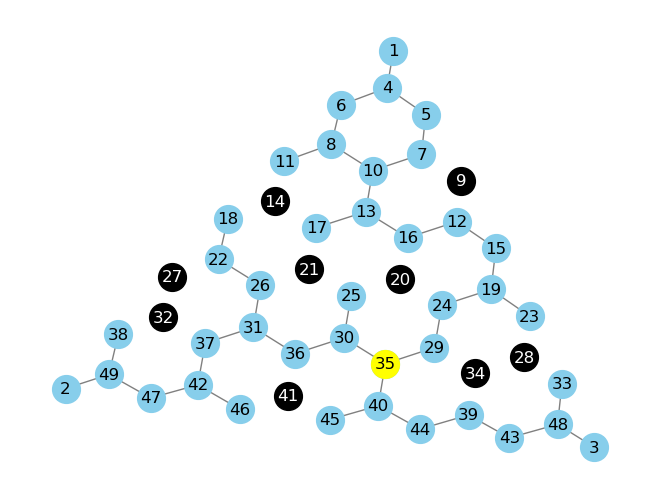

{'barriers': frozenset({32, 34, 41, 9, 14, 20, 21, 27, 28}), 'len12': 21, 'len13': 19, 'len23': 15, 'reward_path_lengths': [21, 19, 15], 'path_length_difference': 6, 'optimal_paths_12': [[1, 4, 5, 7, 10, 13, 16, 12, 15, 19, 24, 29, 35, 30, 36, 31, 37, 42, 47, 49, 2], [1, 4, 6, 8, 10, 13, 16, 12, 15, 19, 24, 29, 35, 30, 36, 31, 37, 42, 47, 49, 2]], 'optimal_paths_13': [[1, 4, 5, 7, 10, 13, 16, 12, 15, 19, 24, 29, 35, 40, 44, 39, 43, 48, 3], [1, 4, 6, 8, 10, 13, 16, 12, 15, 19, 24, 29, 35, 40, 44, 39, 43, 48, 3]], 'optimal_paths_23': [[2, 49, 47, 42, 37, 31, 36, 30, 35, 40, 44, 39, 43, 48, 3]], 'optimal_paths_all': [[1, 4, 5, 7, 10, 13, 16, 12, 15, 19, 24, 29, 35, 30, 36, 31, 37, 42, 47, 49, 2], [1, 4, 6, 8, 10, 13, 16, 12, 15, 19, 24, 29, 35, 30, 36, 31, 37, 42, 47, 49, 2], [1, 4, 5, 7, 10, 13, 16, 12, 15, 19, 24, 29, 35, 40, 44, 39, 43, 48, 3], [1, 4, 6, 8, 10, 13, 16, 12, 15, 19, 24, 29, 35, 40, 44, 39, 43, 48, 3], [2, 49, 47, 42, 37, 31, 36, 30, 35, 40, 44, 39, 43, 48, 3]], 'choice_p

In [11]:
# get a random maze config for testing
maze_config_list = list(good_mazes)

bars = maze_config_list[528]
# print it and visualize it
print(bars)
plot_hex_maze(bars)

# get attributes of this maze
atts = get_maze_attributes(bars)
print(atts)

In [33]:
def single_barrier_moved(barrier_set_1, barrier_set_2):
    ''' Check if two sets of barriers differ by only one element '''
    
    # The symmetric difference (XOR) between the sets must have exactly two elements
    # because each set should have exactly one barrier not present in the other set
    return len(barrier_set_1.symmetric_difference(barrier_set_2)) == 2


def at_least_one_path_shorter_and_longer(paths_1, paths_2):
    ''' 
    Given 2 sets of 3 paths lengths (e.g. [15, 17, 19] and [17, 21, 15]),
    check if at least one corresponding path is shorter AND at least one is longer
    
    Returns: 
    True if at least one path is shorter AND at least one is longer, False otherwise
    '''
    return (any(a < b for a, b in zip(paths_1, paths_2)) and any(a > b for a, b in zip(paths_1, paths_2)))


def get_next_barrier_set(df, original_barriers):
    '''
    Given the hex maze database (df) and set of original barriers, get a list 
    of next barrier sets created by the movement of a single barrier where at 
    least one path increases in length and another decreases in length 
    compared to the original barrier set. 
    
    Returns:
    a list of potential new barrier sets
    '''
    
    # Find other valid mazes in the df that differ by the movement of a single barrier
    potential_new_barriers = [b for b in df['barriers'] if single_barrier_moved(b, original_barriers)]
    
    # Get the lengths of paths between reward ports for the original barrier set
    original_path_lengths = df[(df['barriers'] == original_barriers)]['reward_path_lengths'].item()
    
    # We only want mazes where >=1 path gets longer and >=1 gets shorter compared to the original
    new_barriers = []
    for bar in potential_new_barriers:
        # Get the path lengths between reward ports for this new barrier set
        new_path_lengths = df[(df['barriers'] == bar)]['reward_path_lengths'].item()
        # Only add it to our list if at least one path gets longer and one gets longer
        if at_least_one_path_shorter_and_longer(original_path_lengths, new_path_lengths):
            new_barriers.append(bar)
    return new_barriers
        

# Start with a valid config
original_barriers = df['barriers'][0]
original_path_lengths = df[(df['barriers'] == original_barriers)]['reward_path_lengths'].item()
print("Original barrier set:", original_barriers)
print("Original path lengths between reward ports:", original_path_lengths, "\n")

# Find other configs that differ by the movement of a single barrier
potential_new_barriers = [b for b in df['barriers'] if single_barrier_moved(b, original_barriers)]
print("Potential new barrier sets:")
print(potential_new_barriers, "\n")

new_barriers = []
for bar in potential_new_barriers:
    # Get the path lengths between reward ports for this barrier set
    new_path_lengths = df[(df['barriers'] == bar)]['reward_path_lengths'].item()
    # Now only get the ones where at least one path gets longer and one gets shorter
    if at_least_one_path_shorter_and_longer(original_path_lengths, new_path_lengths):
        new_barriers.append(bar)

print("New barrier sets where at least one path is longer and one is shorter:")
print(new_barriers)

Original barrier set: frozenset({37, 7, 39, 41, 14, 46, 20, 23, 30})
Original path lengths between reward ports: [15, 17, 21] 

Potential new barrier sets:
[frozenset({36, 37, 7, 39, 46, 14, 20, 23, 30}), frozenset({37, 7, 39, 14, 46, 18, 20, 23, 30}), frozenset({37, 7, 39, 41, 14, 18, 20, 23, 30}), frozenset({34, 37, 7, 41, 46, 14, 20, 23, 30}), frozenset({37, 7, 41, 45, 14, 46, 20, 23, 30}), frozenset({37, 39, 7, 41, 44, 14, 20, 23, 30}), frozenset({37, 7, 39, 46, 14, 17, 20, 23, 30}), frozenset({37, 39, 7, 14, 46, 20, 23, 30, 31}), frozenset({37, 39, 7, 46, 14, 20, 23, 25, 30}), frozenset({37, 7, 39, 42, 46, 14, 20, 23, 30}), frozenset({37, 7, 41, 42, 14, 46, 20, 23, 30}), frozenset({37, 39, 7, 41, 45, 14, 20, 23, 30}), frozenset({37, 7, 39, 9, 41, 14, 20, 23, 30}), frozenset({37, 7, 41, 11, 46, 14, 20, 23, 30}), frozenset({37, 7, 41, 44, 14, 46, 20, 23, 30}), frozenset({36, 37, 7, 41, 46, 14, 20, 23, 30}), frozenset({37, 7, 39, 14, 46, 20, 23, 24, 30}), frozenset({37, 7, 39, 44, 46

Original barrier set: frozenset({34, 10, 42, 12, 45, 18, 23, 25, 31}) 



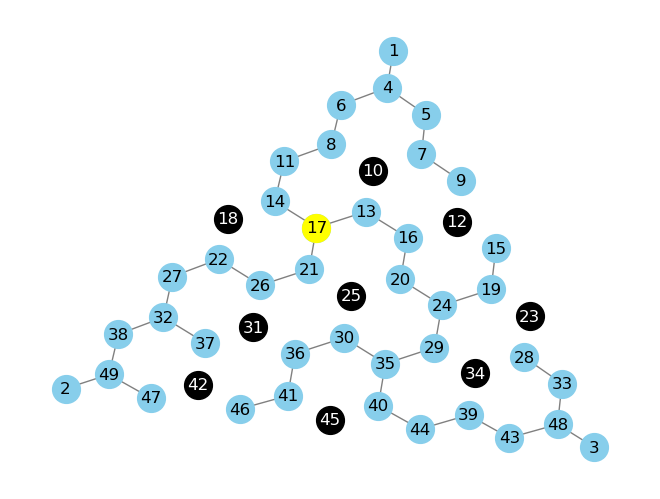

Potential next barriers: frozenset({34, 10, 12, 45, 18, 23, 25, 26, 31}) 



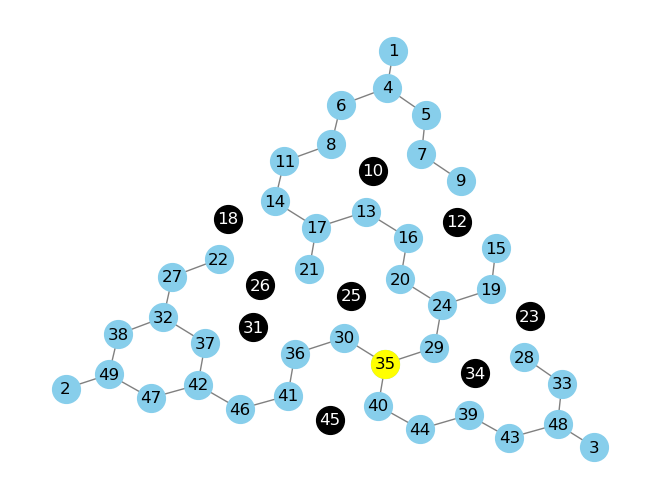

Potential next barriers: frozenset({34, 10, 12, 45, 18, 23, 25, 27, 31}) 



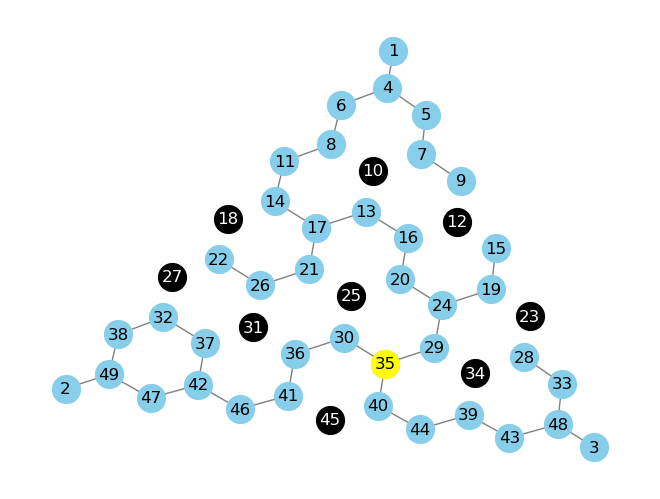

Potential next barriers: frozenset({34, 10, 12, 45, 18, 21, 23, 25, 31}) 



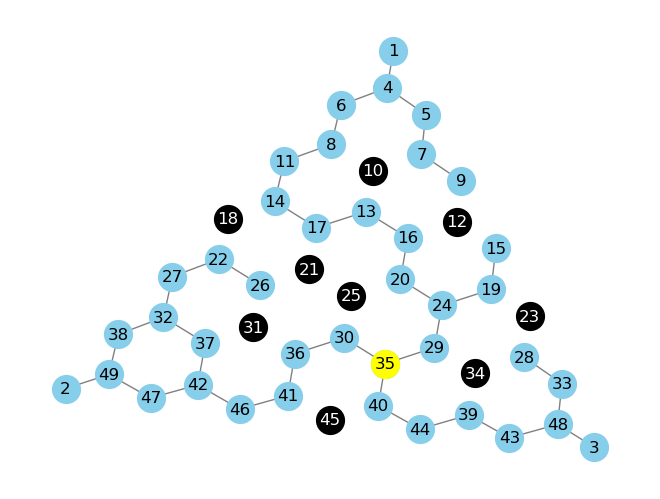

Potential next barriers: frozenset({32, 34, 10, 12, 45, 18, 23, 25, 31}) 



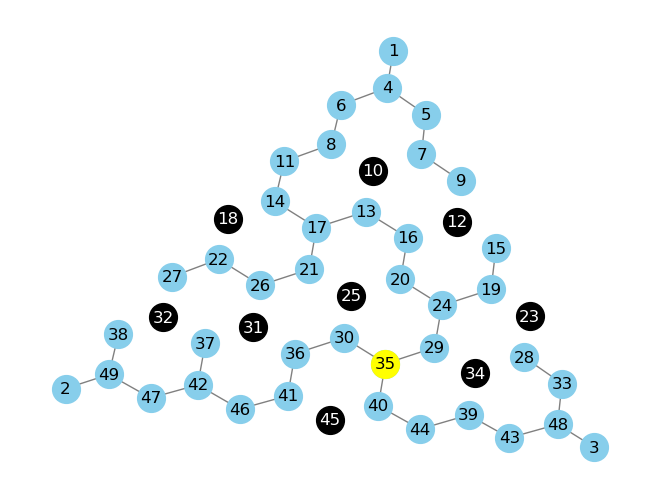

In [37]:
original_barriers  = df['barriers'][3]
print("Original barrier set:", original_barriers, "\n")
plot_hex_maze(original_barriers)

next_barriers = get_next_barrier_set(df, original_barriers)
for b in next_barriers:
    print("Potential next barriers:", b, "\n")
    plot_hex_maze(b)


Original barrier set: frozenset({9, 10, 42, 44, 13, 18, 22, 25, 30}) 



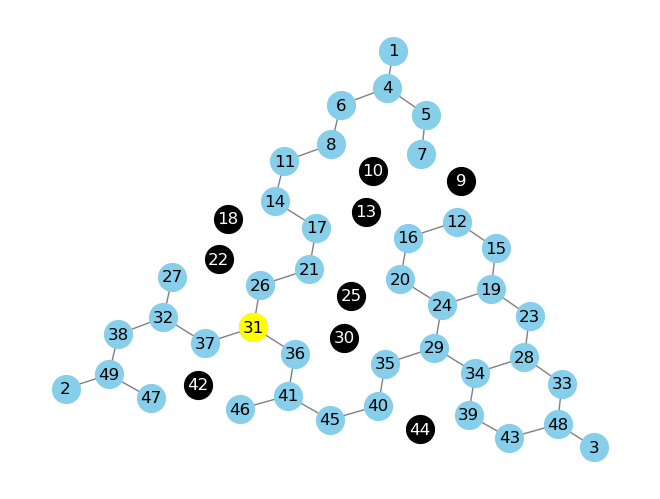

[[28, 33, 48, 43, 39, 34], [24, 19, 23, 28, 34, 29], [24, 20, 16, 12, 15, 19]]
Num cycles: 3
Isomorphic barriers: frozenset({9, 10, 42, 44, 13, 18, 22, 25, 30})
Isomorphic barriers: frozenset({39, 10, 11, 13, 46, 15, 19, 25, 30})
Isomorphic barriers: frozenset({32, 34, 41, 11, 45, 21, 23, 25, 29})
Isomorphic barriers: frozenset({37, 40, 9, 45, 20, 25, 27, 28, 31})
Isomorphic barriers: frozenset({37, 7, 46, 14, 18, 20, 23, 25, 31})
Isomorphic barriers: frozenset({34, 8, 12, 44, 15, 21, 25, 27, 29})


In [65]:
def count_cycles(graph):
    # Find the cycle basis of the graph
    cycle_basis = nx.cycle_basis(graph)
    print(cycle_basis)
    # The number of cycles is the length of the cycle basis
    return len(cycle_basis)


def get_isomorphic_mazes_graph_algo(df, barriers):
    # Get the graph representation of the barrier set
    G = create_maze_graph(barriers)
    # Find other mazes in the dataframe that are isomorphic to the given barrier set
    isomorphic_barriers = [b for b in df['barriers'] if nx.is_isomorphic(create_maze_graph(b), G)]
    return isomorphic_barriers

original_barriers  = df['barriers'][6]
print("Original barrier set:", original_barriers, "\n")
plot_hex_maze(original_barriers)

print("Num cycles:", count_cycles(create_maze_graph(original_barriers)))
    
iso_mazes = get_isomorphic_mazes(df, original_barriers)
for m in iso_mazes:
    print("Isomorphic barriers:", m)
    #plot_hex_maze(m)

In [75]:
def rotate_hex(initial_hex, direction='counterclockwise'):
    '''
    Given a hex in the hex maze, returns the corresponding hex if the maze is rotated once
    counterclockwise (e.g. hex 1 becomes hex 2, 4 becomes 49, etc.). Option to specify
    direction='clockwise' to rotate clockwise instead (e.g 1 becomes 3, 4 becomes 48, etc.)
    
    Returns: 
    the corresponding hex if the maze was rotated once counterclockwise (or clockwise)
    '''
    # Lists of corresponding hexes when the maze is rotated 120 degrees
    hex_rotation_lists = [[1,2,3], [4,49,48], [6,47,33], [5,38,43], [8,42,28], 
                         [7,32,39], [11,46,23], [10,37,34], [9,27,44], [14,41,19],
                         [13,31,29], [12,22,40], [18,45,15], [17,36,24], [16,26,35],
                         [21,30,20], [25]]
    
    for lst in hex_rotation_lists:
        if initial_hex in lst:
            index = lst.index(initial_hex)
            if direction=='clockwise':
                return lst[(index - 1) % len(lst)]
            else: # I choose to assume any direction not specified 'clockwise' is 'counterclockwise'
                return lst[(index + 1) % len(lst)]
    # Return None if the hex to rotate doesn't exist in our rotation lists (all hexes should exist)
    return None  


def reflect_hex(initial_hex, axis=1):
    '''
    Given a hex in the hex maze, returns the corresponding hex if the maze is reflected
    across the axis of hex 1 (e.g. hex 6 becomes hex 5 and vice versa, 8 becomes 7, etc.). 
    Option to specify axis=2 or axis=3 to reflect across the axis of hex 2 or 3 instead.
    
    Returns: 
    the corresponding hex if the maze was reflected across the axis of hex 1 (or 2 or 3)
    '''
    # Lists of corresponding hexes reflected across axis 1, 2, or 3
    reflections_ax1 = [[6,5], [8,7], [11,9], [14,12], [18,15], [17,16], [22,19], 
                      [21,20], [27,23], [26,24], [32,28], [31,29], [38,33], [37,34],
                      [36,35], [49,48], [42,39], [41,40],[2,3], [47,43], [46,44]]
    reflections_ax2 = [[47,38], [42,32], [46,27], [41,22], [45,18], [36,26], [40,14], 
                      [30,21], [44,11], [35,17], [39,8], [29,13], [43,6], [34,10], 
                      [24,16], [48,4], [28,7], [19,12], [3,1], [33,5], [23,9]]
    reflections_ax3 = [[43,33], [39,28], [44,23], [40,19], [45,15], [35,24], [41,12],
                      [30,20], [46,9], [36,16], [42,7], [31,13], [47,5], [37,10],
                      [26,17], [49,4], [32,8], [22,14], [2,1], [38,6], [27,11]]
    # Choose the reflection list for the axis we care about
    hex_reflections = {1: reflections_ax1, 2: reflections_ax2, 3: reflections_ax3}.get(axis, None)
    
    for lst in hex_reflections:
        if initial_hex in lst:
            # Return the other hex in the reflection pair
            return lst[1] if lst[0] == initial_hex else lst[0]
    # If the hex isn't in any list, it doesn't change when the maze is reflected along this axis
    return initial_hex  
    

def get_rotated_barriers(original_barriers, direction='counterclockwise'):
    '''
    Given a set of barriers in the hex maze, returns the corresponding 
    barrier set if the maze is rotated once counterclockwise (e.g. hex 1 becomes hex 2, 
    4 becomes 49, etc.). Option to specify direction='clockwise' to rotate clockwise 
    instead (e.g 1 becomes 3, 4 becomes 48, etc.)
    
    Returns: 
    the barrier set if the maze was rotated once counterclockwise (or clockwise)
    '''
    return {rotate_hex(b, direction) for b in original_barriers}


def get_reflected_barriers(original_barriers, axis=1):
    '''
    Given a set of barriers in the hex maze, returns the corresponding 
    barrier set if the maze is reflected along the axis of hex 1 
    (e.g. hex 6 becomes hex 5 and vice versa, 8 becomes 7 and vice versa, etc.). 
    Option to specify axis=2 or axis=3 to reflect across the axis of hex 2 or 3 instead.
    
    Returns: 
    the barrier set if the maze was reflected across the axis of hex 1 (or 2 or 3)
    '''
    return {reflect_hex(b, axis) for b in original_barriers}


def get_isomorphic_mazes(barriers):
    '''
    Given a set of barriers defining a hex maze configuration, return the
    other 5 barrier sets that have the same graph structure (corresponding
    to the maze rotated clockwise/counterclockwise and reflected across its
    3 axes of symmetry)
    
    Returns:
    a set of the 5 isomorphic barrier sets for this barrier set
    '''
    # Rotate and reflect the maze to get other barrier configs that match
    reflected_ax1 = frozenset(get_reflected_barriers(orig_barriers, axis=1))
    reflected_ax2 = frozenset(get_reflected_barriers(orig_barriers, axis=2))
    reflected_ax3 = frozenset(get_reflected_barriers(orig_barriers, axis=3))
    rotated_ccw = frozenset(get_rotated_barriers(orig_barriers, direction='counterclockwise'))
    rotated_cw = frozenset(get_rotated_barriers(orig_barriers, direction='clockwise'))
    
    return {reflected_ax1, reflected_ax2, reflected_ax3, rotated_ccw, rotated_cw}

orig_barriers  = df['barriers'][2]
print("Original barriers:", orig_barriers)
iso_barriers = get_isomorphic_mazes(orig_barriers)
print("Isomorphic barriers:", iso_barriers)

Original barriers: frozenset({34, 7, 41, 11, 46, 17, 20, 28, 31})
Isomorphic barriers: {frozenset({35, 7, 10, 44, 20, 22, 27, 28, 31}), frozenset({32, 37, 8, 9, 40, 44, 16, 21, 29}), frozenset({32, 36, 8, 10, 46, 19, 21, 23, 29}), frozenset({34, 39, 9, 42, 12, 13, 26, 27, 30}), frozenset({37, 39, 42, 11, 13, 14, 23, 24, 30})}


In [68]:
orig_barriers  = df['barriers'][2]
print("Original barrier set:", orig_barriers, "\n")

rotated_barriers_ccw = get_rotated_barriers(orig_barriers)
print("Rotated barrier set (ccw):", rotated_barriers_ccw, "\n")

rotated_barriers_cw = get_rotated_barriers(orig_barriers, direction='clockwise')
print("Rotated barrier set (cw):", rotated_barriers_cw, "\n")

reflected_barriers_1 = get_reflected_barriers(orig_barriers, axis=1)
print("Reflected barrier set (ax1):", reflected_barriers_1, "\n")

reflected_barriers_2 = get_reflected_barriers(orig_barriers, axis=2)
print("Reflected barrier set (ax2):", reflected_barriers_2, "\n")

reflected_barriers_3 = get_reflected_barriers(orig_barriers, axis=3)
print("Reflected barrier set (ax3):", reflected_barriers_3, "\n")

Original barrier set: frozenset({34, 7, 41, 11, 46, 17, 20, 28, 31}) 

Rotated barrier set: {32, 36, 8, 10, 46, 19, 21, 23, 29} 

Rotated barrier set: {37, 39, 42, 11, 13, 14, 23, 24, 30} 

Reflected barrier set (ax1): {32, 37, 8, 9, 40, 44, 16, 21, 29} 

Reflected barrier set (ax2): {35, 7, 10, 44, 20, 22, 27, 28, 31} 

Reflected barrier set (ax3): {34, 39, 9, 42, 12, 13, 26, 27, 30} 

